Assignment #3:
Problems 1, 2, 3, 5 from Chapter 3 (pages 88-89) 

In [73]:
datadir='../../Datasets/'
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from collections import Counter
import plfit
from scipy.stats import poisson

In [74]:
## Directed degree centrality
def degree_centrality(graph, weights=None):
    n = graph.vcount()

    if graph.is_directed():
        dc = [sum(x)/(2*(n-1)) for x in zip(graph.strength(mode='in', weights=weights), \
            graph.strength(mode='out', weights=weights))]
    else:
        dc = [x/(n-1) for x in graph.strength(weights=weights)]

    return dc

In [75]:
## define edges color
cls_edges = 'gainsboro'

## we will consider 3 types of nodes with the following colors and sizes:
cls = ['silver','dimgray','black']
sz = [6,9,12]

## read edges and build weighted directed graph
D = pd.read_csv(datadir+'Airports/connections.csv')
g = ig.Graph.TupleList([tuple(x) for x in D.values], directed=True, edge_attrs=['weight'])
D.head() ## look at a few edges



,orig_airport,dest_airport,total_passengers
0,SFO,LAX,1442105
1,LAX,SFO,1438639
2,MCO,ATL,1436625
3,ATL,MCO,1424069
4,LAX,JFK,1277731


In [76]:
#Attributes
A = pd.read_csv(datadir+'Airports/airports_loc.csv')
lookup = {k:v for v,k in enumerate(A['airport'])}
l = [lookup[x] for x in g.vs()['name']]
g.vs()['layout'] = [(A['lon'][i],A['lat'][i]) for i in l]
g.vs()['state'] = [A['state'][i] for i in l]
g.vs()['city'] = [A['city'][i] for i in l]
A.head()

,airport,lon,lat,state,city
0,ABE,-75.440804,40.652100,PA,Allentown
1,ABI,-99.681900,32.411301,TX,Abilene
2,ABQ,-106.609001,35.040199,NM,Albuquerque
3,ABR,-98.421799,45.449100,SD,Aberdeen
4,ABY,-84.194504,31.535500,GA,Albany


In [77]:
## add a few more attributes for visualization
g.vs()['size'] = sz[1]
g.vs()['color'] = cls[1]
g.es()['color'] = cls_edges
g.es()['arrow_size'] = 0.33
print(g.vcount(),'nodes and',g.ecount(),'directed edges')

464 nodes and 12000 directed edges


Q1 Find the top 5 ranked airports (with respect to the degree centrality)
in the state of New York. Present results in the same form as
what was done for the state of California|Table 3.3.

In [79]:
## Build smaller subgraph 'G' for NY
G = g.subgraph([v for v in g.vs() if v['state'] == 'NY'])

## drop isolated vertices (i.e. without in-state connections)
G = G.subgraph([v for v in G.vs() if v.degree()>0])

## remove loops if any
G = G.simplify(multiple=False)
print(G.vcount(),'nodes and',G.ecount(),'directed edges')

13 nodes and 50 directed edges


In [80]:
# Compute normalized weights
mw = np.max(G.es['weight'])
G.es()['normalized_weight'] = [w/mw for w in G.es()['weight']]

# Compute several centrality measures for NY subgraph G

C = pd.DataFrame({'airport':G.vs()['name'], \
                   'degree': degree_centrality(G, weights='normalized_weight'),\
                    'pagerank': G.pagerank(weights='weight'), 'authority': G.authority_score(weights='weight'),\
                    'hub':G.hub_score(weights='weight'), 'between':G.betweenness(),\
                    'closeness':G.closeness()})

n = G.vcount()
C['between'] = [2*x/((n-1)*(n-2)) for x in C['between']]
#Sort w.r.t degree centrality, look at top airports
Cs = C.sort_values(by='degree', ascending=False)
Cs.head()

,airport,degree,pagerank,authority,hub,between,closeness
0,JFK,0.173125,0.342720,1.000000,0.373760,0.647727,0.705882
2,BUF,0.101629,0.195702,0.261299,1.000000,0.167929,0.705882
4,ROC,0.054908,0.109433,0.141841,0.546989,0.000000,0.631579
5,SYR,0.044959,0.097118,0.113975,0.459400,0.243687,0.750000
1,LGA,0.040011,0.108312,0.213367,0.078989,0.286616,0.750000


Q2 Generate Chung-Lu graph G(w) on n = 10;000 nodes and powerlaw
degree distribution using the set of weights prescribed by (2.6)
with gamma = 2:5, delta = 1, and max_delta = sqrt(n) = 100. (We experimented with
this model in Section 2.5.) For each centrality measure (degree,
pagerank, authority, hub, between, closeness) compute f(k), the
average centrality measure over all nodes of degree k. Plot f(k)
as a function of k. Is there any visible correlation between a given
centrality measure and the degree of a node?

In [81]:
## fast Chung-Lu: generate m edges w.r.t. distribution d
def fastCL(d, m):
    n = len(d)
    s = np.sum(d)
    p = [i/s for i in d]
    target = m
    tples = []
    ## generate edges (tuples), drop collisions, until m edges are obtained.
    while len(tples) < target:
        s = target - len(tples)
        e0 = np.random.choice(n, size=s, replace=True, p=p)
        e1 = np.random.choice(n, size=s, replace=True, p=p)
        tples.extend([(min(e0[i],e1[i]),max(e0[i],e1[i]), 1.0) for i in range(len(e0)) if e0[i]!=e1[i]]) ## ignore loops, 1.0 is edge weight
        tples = list(set(tples)) ## drop collisions
    return tples

In [84]:
## power law graph
gamma = 2.5
n = 10000

## min and max degrees
delta = 1
Delta = np.sqrt(n)

W = []
for i in np.arange(1,n+1):
    W.append(delta * (n/(i-1+n/(Delta/delta)**(gamma-1)))**(1/(gamma-1)))

deg = W

## generate graph with Chung-Lu model
m = int(np.mean(deg)*n/2)
tpl = fastCL(deg,m)
g1 = ig.Graph.TupleList(tpl, weights=True)

## number of isolated nodes (no edges)
iso = n-g1.vcount()
print('isolates:',iso)

isolates: 1870


In [91]:
# Degree, 
# pagerank - need vertex list
# authority - edge list associated with node?
# hub, between, closeness

mw = np.max(g1.es['weight'])
g1.es()['normalized_weight'] = [w/mw for w in g1.es()['weight']]

output_df = pd.DataFrame({ 'degree':g1.degree(), 'degree_centrality': degree_centrality(g1, weights='normalized_weight'),\
                    'pagerank': g1.pagerank(weights='weight'), 'authority': g1.authority_score(weights='weight'),\
                    'hub':g1.hub_score(weights='weight'), 'between':g1.betweenness(),\
                    'closeness':g1.closeness()})

n = g1.vcount()
output_df['between'] = [2*x/((n-1)*(n-2)) for x in output_df['between']]

output_df.head()

,degree,degree_centrality,pagerank,authority,hub,between,closeness
0,18,0.002214,0.000529,0.054908,0.054908,0.004651,0.231103
1,1,0.000123,0.000043,0.003952,0.003952,0.000000,0.187725
2,11,0.001353,0.000376,0.093905,0.093905,0.003979,0.232386
3,2,0.000246,0.000078,0.006977,0.006977,0.000052,0.188850
4,2,0.000246,0.000099,0.000702,0.000702,0.000236,0.165490


In [92]:
avg_df = output_df.groupby(by=["degree"], as_index = False).mean()
avg_df.head()

,degree,degree_centrality,pagerank,authority,hub,between,closeness
0,1,0.000123,0.000058,0.003984,0.003984,0.000000,0.252481
1,2,0.000246,0.000085,0.007642,0.007642,0.000118,0.195049
2,3,0.000369,0.000114,0.011162,0.011162,0.000252,0.190537
3,4,0.000492,0.000140,0.015182,0.015182,0.000394,0.197896
4,5,0.000615,0.000169,0.019054,0.019054,0.000587,0.202488


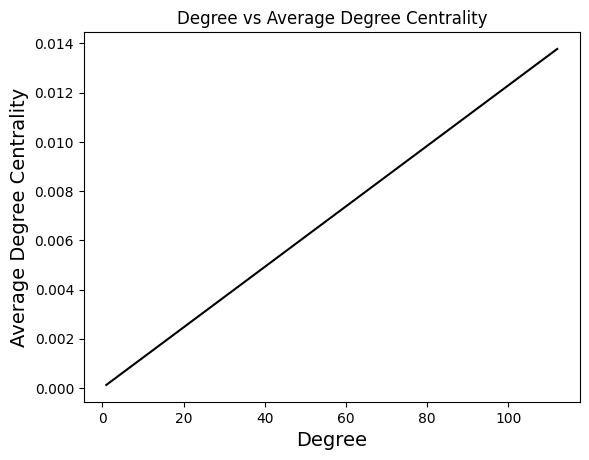

In [93]:
import matplotlib.pyplot as plt

plt.plot(avg_df["degree"], avg_df["degree_centrality"], color='black')
plt.title('Degree vs Average Degree Centrality')
plt.xlabel('Degree',fontsize=14)
plt.ylabel('Average Degree Centrality',fontsize=14);
plt.show()


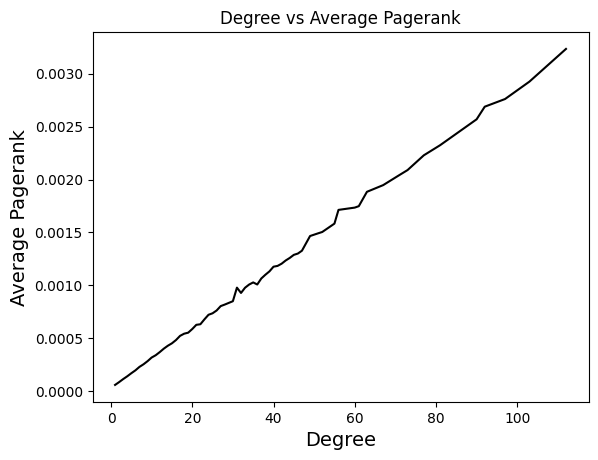

In [94]:
plt.plot(avg_df["degree"], avg_df["pagerank"], color='black')
plt.title('Degree vs Average Pagerank')
plt.xlabel('Degree',fontsize=14)
plt.ylabel('Average Pagerank',fontsize=14);
plt.show()

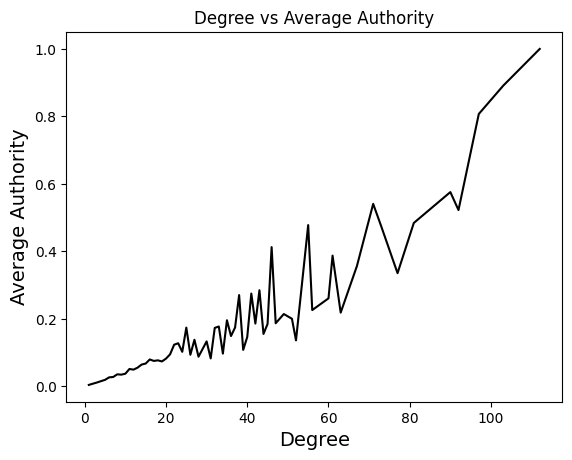

In [95]:
plt.plot(avg_df["degree"], avg_df["authority"], color='black')
plt.title('Degree vs Average Authority')
plt.xlabel('Degree',fontsize=14)
plt.ylabel('Average Authority',fontsize=14);
plt.show()

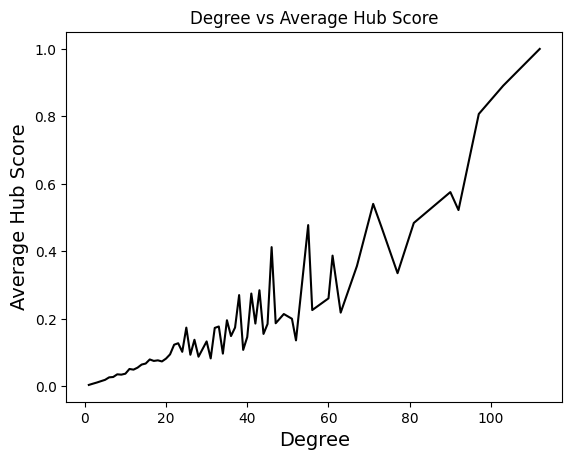

In [96]:
plt.plot(avg_df["degree"], avg_df["hub"], color='black')
plt.title('Degree vs Average Hub Score')
plt.xlabel('Degree',fontsize=14)
plt.ylabel('Average Hub Score',fontsize=14)
plt.show()

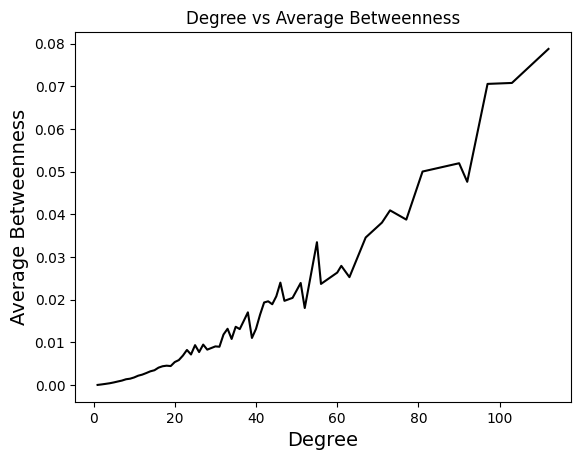

In [97]:
plt.plot(avg_df["degree"], avg_df["between"], color='black')
plt.title('Degree vs Average Betweenness')
plt.xlabel('Degree',fontsize=14)
plt.ylabel('Average Betweenness',fontsize=14)
plt.show()

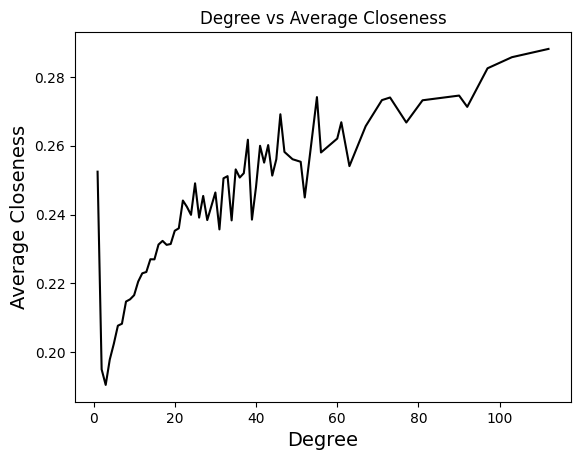

In [98]:
plt.plot(avg_df["degree"], avg_df["closeness"], color='black')
plt.title('Degree vs Average Closeness')
plt.xlabel('Degree',fontsize=14)
plt.ylabel('Average Closeness',fontsize=14)
plt.show()

Centrality measure correlation discussion

Degree Centrality: Here there is a direct linear correlation.

Pagerank: There is a slightly less linear correlation, but still more linear than the rest of the measures. 

Authority: Erratic linear correlation as the degree increases

Hub: Erratic linear correlation as the degree increases

Betweenness: Erratic linear correlation as the degree increases

Closeness: Poor linear correlation at very low degrees, with an erratically linear correlation elsewhere.



Degree centrality and pagerank both have strong linear correlation, with the degree centrality in particular showing a linear relationship. Generally speaking for all scores, higher degrees tend to lead to better scores on our centrality measures. This is to be expected as nodes with higher degrees are more likely to form important connections just by virtue of having more neighbours.

Q3 The original airport dataset (464 nodes, 12,000 directed weighted
edges) is not strongly connected but it is almost weakly connected.
There are two weak components: the giant one consisting of all but
two airports, and the small one with two airports that only link to
each other. Remove the two nodes to make the graph weakly connected.
For each centrality measure (degree, pagerank, authority,
hub, between, closeness) perform the following experiment: sort all
nodes with respect to a given centrality measure. How many nodes
with the largest score do we need to remove so that the graph is no
longer weakly connected? Compare this with the number of nodes
with the smallest score that need to be removed.

In [99]:
## read edges and build weighted directed graph
D = pd.read_csv(datadir+'Airports/connections.csv')
g = ig.Graph.TupleList([tuple(x) for x in D.values], directed=True, edge_attrs=['weight'])
D.head() ## look at a few edges
## read vertex attributes and add to graph
A = pd.read_csv(datadir+'Airports/airports_loc.csv')
lookup = {k:v for v,k in enumerate(A['airport'])}
l = [lookup[x] for x in g.vs()['name']]
g.vs()['layout'] = [(A['lon'][i],A['lat'][i]) for i in l]
g.vs()['state'] = [A['state'][i] for i in l]
g.vs()['city'] = [A['city'][i] for i in l]
A.head() ## first few rows in A
print(g.vcount(),'nodes and',g.ecount(),'directed edges')

full_graph = g
weak_component = full_graph.connected_components(mode="weak")[0]
weak_subgraph = full_graph.subgraph(weak_component)
print(weak_subgraph.vcount(),'nodes and',weak_subgraph.ecount(),'directed edges')
print(weak_subgraph.is_connected(mode="weak"))

464 nodes and 12000 directed edges
462 nodes and 11999 directed edges
True


In [100]:
def get_df(g):

    mw = np.max(g.es['weight'])
    g.es()['normalized_weight'] = [w/mw for w in g.es()['weight']]

    g_df = pd.DataFrame({ 'vertex_index': g.vs().indices,  'Name': g.vs()["name"], \
                   'degree_centrality': degree_centrality(g, weights='normalized_weight'),\
                    'pagerank': g.pagerank(weights='weight'), 'authority': g.authority_score(weights='weight'),\
                    'hub':g.hub_score(weights='weight'), 'between':g.betweenness(),\
                    'closeness':g.closeness()})

    return g_df

weak_subgraph_df = get_df(weak_subgraph)
columns = weak_subgraph_df.columns
metrics = columns[2:]

weak_subgraph_df.head()

,vertex_index,Name,degree_centrality,pagerank,authority,hub,between,closeness
0,0,SFO,0.019337,0.017986,0.572323,0.574479,3718.913507,0.544917
1,1,LAX,0.029707,0.026628,0.765373,0.768892,5479.365466,0.559466
2,2,MCO,0.021867,0.019390,0.564857,0.565243,2988.693784,0.551435
3,3,ATL,0.053397,0.051320,1.000000,1.000000,9400.702876,0.593308
4,4,JFK,0.016892,0.014496,0.445176,0.446092,1263.494964,0.532333


In [7]:
def remove_indices(sort_ascending):

    for col_name in metrics:

        new_subgraph = weak_subgraph.copy()
        new_subgraph_df = weak_subgraph_df
        connected_result = new_subgraph.is_connected(mode="weak")
        num_removed = 0
        
        while connected_result:
            new_subgraph_df = get_df(new_subgraph)
            sorted_df = new_subgraph_df.sort_values(by=col_name, ascending=sort_ascending)
            index_to_remove = sorted_df.iloc[0]["vertex_index"]
            new_subgraph.delete_vertices(index_to_remove)
            connected_result = new_subgraph.is_connected(mode="weak")
            
            num_removed += 1

            if num_removed == 461:
                break

        print(f"Removed {num_removed} for {col_name}")

print("DESCENDING")
remove_indices(sort_ascending=False)

print("ASCENDING")
remove_indices(sort_ascending=True)

DESCENDING
Removed 2 for degree_centrality
Removed 2 for pagerank
Removed 2 for authority
Removed 2 for hub
Removed 4 for between
Removed 1 for closeness
ASCENDING
Removed 178 for degree_centrality
Removed 39 for pagerank
Removed 6 for authority
Removed 11 for hub
Removed 66 for between
Removed 461 for closeness


We see across all metrics that we need to remove far fewer important nodes to cause a graph to be no longer connected when compared to the least significant nodes. This is to be expected as the most significant nodes are much more likely to be key connections in the graph where there are no other nodes that make the same connections.

Q5: From the airport graph, generate a state-to-state graph by collapsing
every node in a state to a single node, adding the edge weights
and removing loops (edges between airports in the same state). In
igraph, the function contract vertices() can be used to do this.
Let G be this new graph with 51 nodes (the 50 states plus DC).

a) Is G weakly connected? Strongly connected?
b) Which state has the most incoming passengers? The most departing
passengers?
c) Which pair of two states, x and y, have the most passengers
travelling from x to y (directed weight)?
d) Recreate Table 3.3 for graph G. Which states have the highest
degree centrality? Betweenness centrality?

In [16]:
## read edges and build weighted directed graph
D = pd.read_csv(datadir+'Airports/connections.csv')
g = ig.Graph.TupleList([tuple(x) for x in D.values], directed=True, edge_attrs=['weight'])
D.head() ## look at a few edges
## read vertex attributes and add to graph
A = pd.read_csv(datadir+'Airports/airports_loc.csv')
lookup = {k:v for v,k in enumerate(A['airport'])}
l = [lookup[x] for x in g.vs()['name']]
g.vs()['layout'] = [(A['lon'][i],A['lat'][i]) for i in l]
g.vs()['state'] = [A['state'][i] for i in l]
g.vs()['city'] = [A['city'][i] for i in l]
A.head() ## first few rows in A
print(g.vcount(),'nodes and',g.ecount(),'directed edges')

total_graph = g

464 nodes and 12000 directed edges


In [37]:
total_df = pd.DataFrame({ 'vertex_index': total_graph.vs().indices,  'name': total_graph.vs()["name"], 'state': total_graph.vs()["state"]}).sort_values(by="state")

mapping_list = [None] * len(total_df)
total_df["state_index"] = mapping_list

states = total_df["state"].unique()


cur_state = total_df.iloc[0]["state"]
cur_state_index = 0
state_new_index_map = dict()
for v_index, state in zip(total_df["vertex_index"], total_df["state"]):
    
    state_new_index_map[cur_state_index] = cur_state
    if cur_state != state:        
        cur_state = state
        cur_state_index += 1

    mapping_list[v_index] = cur_state_index

collapsed_graph = total_graph.copy()
collapsed_graph.contract_vertices(mapping_list)

for key in state_new_index_map:
    collapsed_graph.vs[key]["state"] = state_new_index_map[key]

print(collapsed_graph.vcount(),'nodes and',collapsed_graph.ecount(),'directed edges')

51 nodes and 12000 directed edges


In [21]:
# a) is graph weakly connected? Strongly connected?
print(f"Graph is strongly connected: {collapsed_graph.is_connected(mode='strong')}")
print(f"Graph is weakly connected: {collapsed_graph.is_connected(mode='weak')}")

Graph is strongly connected: True
Graph is weakly connected: True


In [46]:
#b) which state has the most incoming passengers? The most departing passengers?

max_incoming = 0
max_incoming_state = ""
max_outgoing = 0
max_outgoing_state = ""

for v in collapsed_graph.vs():
    in_total_passengers = v.strength(mode="in")

    if in_total_passengers > max_incoming:
        max_incoming_state = v["state"]
        max_incoming = in_total_passengers

    out_total_passengers = v.strength(mode="out")

    if out_total_passengers > max_outgoing:
        max_outgoing_state = v["state"]
        max_outgoing = out_total_passengers

print(f"Max incoming state is: {max_incoming_state} Incoming Passengers: {max_incoming}")
print(f"Max outgoing state is {max_outgoing_state} Outgoing Passengers: {max_outgoing}")


Max incoming state is: TX Incoming Passengers: 1231.0
Max outgoing state is TX Outgoing Passengers: 967.0


In [62]:
#c) Which pair of two states, x and y, have the most passengers travelling from x to y (directed weight)?
vertex_list = collapsed_graph.vs()
index_1 = 0
index_2 = 0

max_travellers = 0
max_states = []
while index_1 < len(vertex_list):
    
    index_2 = 0

    if index_1 == index_2:
        index_1 += 1
        continue

    #print(f"Evaluating {vertex_list[index_1]['state']}") #debug statement

    while index_2 < len(vertex_list):

        sub_graph = collapsed_graph.subgraph([index_1, index_2])
        subgraph_vs = sub_graph.vs()

        if len(subgraph_vs) < 2:
            index_2 += 1
            continue

        x = subgraph_vs[0]
        y = subgraph_vs[1]
        
        x_to_y_passengers = x.strength(mode="out")
        x_to_y_states = [x["state"], y["state"]]

        #print(f"Evaluating {vertex_list[index_1]['state']} to {vertex_list[index_2]['state']} Passengers: {x_to_y_passengers}") #debug statement

        if max_travellers < x_to_y_passengers:

            max_travellers = x_to_y_passengers
            max_states = x_to_y_states

        index_2 += 2

    index_1 += 1

print(f"Max from {max_states[0]} to {max_states[1]}")
print(f"Max Passengers: {max_travellers}")

Max from TX to WI
Max Passengers: 248.0


In [102]:
#d) Recreate Table 3.3 for graph G. Which states have the highest degree centrality? Betweenness centrality?
mw = np.max(collapsed_graph.es['weight'])
collapsed_graph.es()['normalized_weight'] = [w/mw for w in collapsed_graph.es()['weight']]

collapsed_df = pd.DataFrame({ 'state': collapsed_graph.vs()["state"],\
                'degree_centrality': degree_centrality(collapsed_graph, weights='normalized_weight'),\
                'pagerank': collapsed_graph.pagerank(weights='weight'), 'authority': collapsed_graph.authority_score(weights='weight'),\
                'hub':collapsed_graph.hub_score(weights='weight'), 'between':collapsed_graph.betweenness(),\
                'closeness':collapsed_graph.closeness()})

n = collapsed_graph.vcount()
collapsed_df['between'] = [2*x/((n-1)*(n-2)) for x in collapsed_df['between']]

high_degree_df = collapsed_df.sort_values(by="degree_centrality", ascending=False)
high_degree_df.head()

,state,degree_centrality,pagerank,authority,hub,between,closeness
43,TX,0.824127,0.093499,1.000000,1.000000,0.089665,0.980392
4,CA,0.818358,0.086750,0.954129,0.953015,0.066417,0.943396
9,FL,0.656727,0.073113,0.555008,0.554986,0.044062,0.943396
10,GA,0.510587,0.061061,0.433834,0.433670,0.014013,0.961538
14,IL,0.483197,0.059022,0.402050,0.401475,0.053512,1.000000


In [103]:
high_degree_df = collapsed_df.sort_values(by="between", ascending=False)
high_degree_df.head()

,state,degree_centrality,pagerank,authority,hub,between,closeness
43,TX,0.824127,0.093499,1.000000,1.000000,0.089665,0.980392
4,CA,0.818358,0.086750,0.954129,0.953015,0.066417,0.943396
14,IL,0.483197,0.059022,0.402050,0.401475,0.053512,1.000000
35,OH,0.226723,0.028922,0.178017,0.177940,0.047209,0.980392
9,FL,0.656727,0.073113,0.555008,0.554986,0.044062,0.943396
